In [1]:
import duckdb
import pandas as pd
import graphviz

# No need to import duckdb_engine
#  jupysql will auto-detect the driver needed based on the connection string!

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

In [2]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [3]:
%sql duckdb:///:default:
# %sql duckdb:///:memory:
# %sql duckdb:///path/to/file.db

In [4]:
%%sql
CREATE OR REPLACE VIEW stg_weight_log AS
SELECT
  "Date" AS dt,
  "Weight (lbs)" AS weight
FROM read_csv_auto('running_log.csv')
WHERE weight IS NOT NULL;

FROM stg_weight_log LIMIT 10;

,dt,weight
0,2023-07-09,222.2
1,2023-07-10,221.0
2,2023-07-11,222.2
3,2023-07-12,220.2
4,2023-07-13,221.0
5,2023-07-14,221.0
6,2023-07-15,219.0
7,2023-07-16,218.6
8,2023-07-17,222.0
9,2023-07-18,221.8


In [5]:
%%sql
CREATE OR REPLACE VIEW stg_running_log AS
SELECT
  "Date" AS dt,
  "Run Type" AS run_type,
  "Treadmill?" AS is_treadmill,
  "Distance (mi)" AS distance,
  date_diff('second', TIME '00:00:00', "Moving Time") AS moving_time_duration_seconds,
  date_diff('second', TIME '00:00:00', "Strava Pace") AS strava_pace_duration_seconds,
  CAST("AVG HR" AS DOUBLE) AS hr_avg,
  CAST("Resting HR" AS DOUBLE) AS hr_rest
FROM read_csv_auto('running_log.csv')
WHERE run_type != '';

FROM stg_running_log LIMIT 10;

,dt,run_type,is_treadmill,distance,moving_time_duration_seconds,strava_pace_duration_seconds,hr_avg,hr_rest
0,2023-07-09,Rest,False,0.0,NaN,NaN,NaN,69.0
1,2023-07-10,Easy,False,1.7,1652.0,993.0,129.0,69.0
2,2023-07-11,Easy,False,1.7,1660.0,984.0,127.0,67.0
3,2023-07-12,Easy,False,1.7,1691.0,971.0,129.0,66.0
4,2023-07-13,Rest,False,0.0,NaN,NaN,NaN,68.0
5,2023-07-14,Easy,False,1.7,1699.0,982.0,126.0,68.0
6,2023-07-15,Long,False,5.0,5105.0,1019.0,134.0,64.0
7,2023-07-16,Rest,False,0.0,NaN,NaN,NaN,66.0
8,2023-07-17,Easy,False,2.0,1982.0,980.0,126.0,65.0
9,2023-07-18,Easy,False,2.0,1942.0,962.0,125.0,65.0


# Warehouse plan

1. dim calendar
1. dim heart rate zone
1. dim run type
1. fact weight
1. fact runs

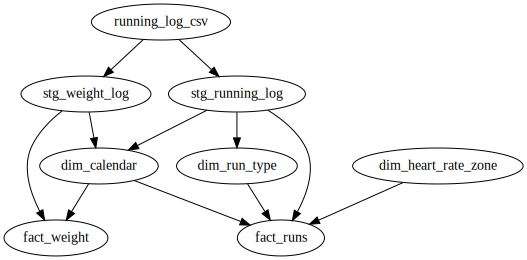

In [6]:
dot_data = '''
digraph {
    running_log_csv -> stg_weight_log;
    running_log_csv -> stg_running_log;
    {
        stg_weight_log
        stg_running_log
    } -> dim_calendar;
    stg_running_log -> dim_run_type;
    dim_heart_rate_zone;
    {
        stg_running_log
        dim_calendar
        dim_run_type
        dim_heart_rate_zone
    } -> fact_runs
    {
        stg_weight_log
        dim_calendar
    } -> fact_weight
}
'''
graph = graphviz.Source(dot_data)
graph

In [24]:
%%sql
CREATE OR REPLACE TABLE dim_heart_rate_zone AS
SELECT
    zone_number AS zone_key,
    coalesce(min_pct,'-Infinity') as min_pct,
    coalesce(lead(min_pct) OVER (ORDER BY zone_number),'Infinity') AS max_pct,
    zone_number,
    zone_name,
    effort_level,
    perceived_exertion,
    benefits
FROM
    read_csv_auto('hr_zones.csv');
    
FROM dim_heart_rate_zone LIMIT 10;

,zone_key,min_pct,max_pct,zone_number,zone_name,effort_level,perceived_exertion,benefits
0,0,-Infinity,0.5,0,Zone 0,Inactive,Not working.,Not doing enough to be considered activity.
1,1,0.5,0.6,1,Zone 1,Warm Up,"Relaxed, easy pace, rhythmic breathing.","Beginning-level aerobic training, reduces stress."
2,2,0.6,0.7,2,Zone 2,Easy,"Comfortable pace, slightly deeper breathing, c...","Basic cardiovascular training, good recovery p..."
3,3,0.7,0.8,3,Zone 3,Aerobic,"Moderate pace, more difficult to hold conversa...","Improved aerobic capacity, optimal cardiovascu..."
4,4,0.8,0.9,4,Zone 4,Threshold,"Fast pace and a bit uncomfortable, breathing f...","Improved anaerobic capacity and threshold, imp..."
5,5,0.9,Infinity,5,Zone 5,Maximum,"Sprinting pace, unsustainable for long period ...","Anaerobic and muscular endurance, increased po..."


In [8]:
%%sql
CREATE OR REPLACE TABLE dim_calendar AS
with all_dt AS (
    SELECT dt FROM stg_running_log
    UNION
    SELECT dt FROM stg_weight_log
), distinct_dt AS (
    SELECT DISTINCT dt FROM all_dt ORDER BY dt ASC
)
SELECT
    -- day
    dt AS date_key,
    dayofyear(dt) AS day_of_year,
    dayofmonth(dt) AS day_of_month,
    dayofweek(dt) AS day_of_week,
    dayname(dt) AS day_name,
    left(dayname(dt), 3) AS day_name_short,
    CASE dayofweek(dt)
        WHEN 0 THEN 'U'
        WHEN 1 THEN 'M'
        WHEN 2 THEN 'T'
        WHEN 3 THEN 'W'
        WHEN 4 THEN 'R'
        WHEN 5 THEN 'F'
        ELSE 'S'
    END AS day_name_single_letter,
    CASE WHEN isodow(dt) < 6 THEN TRUE ELSE FALSE END AS is_weekday,
    -- week
    yearweek(dt) AS week_key,
    date_trunc('week', dt) AS first_day_of_week,
    -- month
    year(dt) || right('0' || month(dt), 2) AS month_key,
    date_trunc('month', dt) AS first_day_of_month,
    month(dt) AS month_of_year,
    left(monthname(dt), 3) AS month_name_short,
    monthname(dt) AS month_name,
    -- season
    CASE
        WHEN month(dt) = 12 THEN year(dt)+1 || '1'
        ELSE year(dt) || ((month(dt)+2)::integer/3)::integer
    END AS season_key,
    CASE
        WHEN month(dt) < 3 THEN make_date(year(dt)-1,12,21)
        WHEN month(dt) < 6 THEN make_date(year(dt),3,20)
        WHEN month(dt) < 9 THEN make_date(year(dt),6,21)
        WHEN month(dt) < 12 THEN make_date(year(dt),9,22)
        ELSE make_date(year(dt),12,21)
    END AS first_day_of_season,
    CASE
        WHEN month(dt) = 12 THEN 1
        ELSE ((month(dt)+2)::integer/3)::integer
    END AS season_of_year,
    CASE
        WHEN month(dt) < 3 THEN 'winter'
        WHEN month(dt) < 6 THEN 'spring'
        WHEN month(dt) < 9 THEN 'summer'
        WHEN month(dt) < 12 THEN 'fall'
        ELSE 'winter'
    END AS season_name,
    -- year
    year(dt) AS year_key,
    date_trunc('year', dt) AS first_day_of_year
FROM distinct_dt;

FROM dim_calendar LIMIT 10;

,date_key,day_of_year,day_of_month,day_of_week,day_name,day_name_short,day_name_single_letter,is_weekday,week_key,first_day_of_week,...,first_day_of_month,month_of_year,month_name_short,month_name,season_key,first_day_of_season,season_of_year,season_name,year_key,first_day_of_year
0,2023-07-09,190,9,0,Sunday,Sun,U,False,202327,2023-07-03,...,2023-07-01,7,Jul,July,20233,2023-06-21,3,summer,2023,2023-01-01
1,2023-07-10,191,10,1,Monday,Mon,M,True,202328,2023-07-10,...,2023-07-01,7,Jul,July,20233,2023-06-21,3,summer,2023,2023-01-01
2,2023-07-11,192,11,2,Tuesday,Tue,T,True,202328,2023-07-10,...,2023-07-01,7,Jul,July,20233,2023-06-21,3,summer,2023,2023-01-01
3,2023-07-12,193,12,3,Wednesday,Wed,W,True,202328,2023-07-10,...,2023-07-01,7,Jul,July,20233,2023-06-21,3,summer,2023,2023-01-01
4,2023-07-13,194,13,4,Thursday,Thu,R,True,202328,2023-07-10,...,2023-07-01,7,Jul,July,20233,2023-06-21,3,summer,2023,2023-01-01
5,2023-07-14,195,14,5,Friday,Fri,F,True,202328,2023-07-10,...,2023-07-01,7,Jul,July,20233,2023-06-21,3,summer,2023,2023-01-01
6,2023-07-15,196,15,6,Saturday,Sat,S,False,202328,2023-07-10,...,2023-07-01,7,Jul,July,20233,2023-06-21,3,summer,2023,2023-01-01
7,2023-07-16,197,16,0,Sunday,Sun,U,False,202328,2023-07-10,...,2023-07-01,7,Jul,July,20233,2023-06-21,3,summer,2023,2023-01-01
8,2023-07-17,198,17,1,Monday,Mon,M,True,202329,2023-07-17,...,2023-07-01,7,Jul,July,20233,2023-06-21,3,summer,2023,2023-01-01
9,2023-07-18,199,18,2,Tuesday,Tue,T,True,202329,2023-07-17,...,2023-07-01,7,Jul,July,20233,2023-06-21,3,summer,2023,2023-01-01


In [9]:
%%sql
CREATE OR REPLACE TEMP MACRO gen_run_type_key(rt) AS hash(lcase(nfc_normalize(rt)));
CREATE OR REPLACE TABLE dim_run_type(run_type_key UBIGINT PRIMARY KEY, run_type VARCHAR);
INSERT OR REPLACE INTO dim_run_type
SELECT DISTINCT ON (gen_run_type_key(run_type))
    hash(lcase(nfc_normalize(run_type))) AS run_type_key,
    run_type
FROM stg_running_log;
FROM dim_run_type LIMIT 10;

,run_type_key,run_type
0,10424679922502887625,Rest
1,14001980879740921682,Easy
2,17495597689471579130,Long
3,5787017974907595517,Threshold
4,17003427173199103894,Recover


In [10]:
%%sql
CREATE OR REPLACE TABLE fact_weight(date_key DATE PRIMARY KEY, weight DOUBLE NOT NULL, inserted_ts TIMESTAMP);
INSERT OR REPLACE INTO fact_weight
WITH joined AS (
SELECT
    cal.date_key AS date_key,
    stg.weight AS weight,
FROM
    stg_weight_log stg
    INNER JOIN dim_calendar cal ON stg.dt = cal.date_key
),
agg AS (
SELECT
    date_key,
    avg(weight) AS weight
FROM
    joined
GROUP BY 1
)
SELECT
    date_key,
    weight,
    current_timestamp AS inserted_ts
FROM
    agg;
FROM fact_weight LIMIT 10;

,date_key,weight,inserted_ts
0,2023-07-09,222.2,2023-08-12 20:26:49.924
1,2023-07-10,221.0,2023-08-12 20:26:49.924
2,2023-07-11,222.2,2023-08-12 20:26:49.924
3,2023-07-12,220.2,2023-08-12 20:26:49.924
4,2023-07-13,221.0,2023-08-12 20:26:49.924
5,2023-07-14,221.0,2023-08-12 20:26:49.924
6,2023-07-15,219.0,2023-08-12 20:26:49.924
7,2023-07-16,218.6,2023-08-12 20:26:49.924
8,2023-07-17,222.0,2023-08-12 20:26:49.924
9,2023-07-18,221.8,2023-08-12 20:26:49.924


In [11]:
%sql CREATE TEMPORARY SEQUENCE fact_runs_key

,Success


In [28]:
%%sql
CREATE OR REPLACE TABLE fact_runs AS
WITH calc AS (
    SELECT
        *,
        moving_time_duration_seconds/distance AS clock_pace_duration_seconds,
        (moving_time_duration_seconds/60)*hr_avg AS heart_beats_total,
        heart_beats_total/distance AS heart_beats_per_mile,
        220-date_diff('year', DATE '1984-01-01', dt) AS hr_est_max,
        hr_avg/hr_est_max AS hr_ratio_basic,
        CASE WHEN is_treadmill THEN 1 ELSE 0 END AS treadmill_ct
    FROM stg_running_log
),
keyed AS (
    SELECT
        nextval('fact_runs_key') AS fact_runs_key,
        cal.date_key,
        rt.run_type_key,
        hrz.zone_key,
        calc.*,
    FROM calc
        INNER JOIN dim_calendar cal ON calc.dt = cal.date_key
        INNER JOIN dim_run_type rt ON gen_run_type_key(calc.run_type) = rt.run_type_key AND rt.run_type != 'Rest'
        INNER JOIN dim_heart_rate_zone hrz ON calc.hr_ratio_basic BETWEEN hrz.min_pct AND hrz.max_pct
)
SELECT
    fact_runs_key,
    date_key,
    run_type_key,
    zone_key,
    is_treadmill,
    treadmill_ct,
    distance,
    moving_time_duration_seconds,
    strava_pace_duration_seconds,
    clock_pace_duration_seconds,
    hr_avg,
    hr_rest,
    hr_est_max,
    hr_ratio_basic,
    heart_beats_total,
    heart_beats_per_mile,
    current_timestamp AS inserted_ts
FROM keyed;

FROM fact_runs LIMIT 10;

,fact_runs_key,date_key,run_type_key,zone_key,is_treadmill,treadmill_ct,distance,moving_time_duration_seconds,strava_pace_duration_seconds,clock_pace_duration_seconds,hr_avg,hr_rest,hr_est_max,hr_ratio_basic,heart_beats_total,heart_beats_per_mile,inserted_ts
0,568,2023-07-19,14001980879740921682,2,False,0,2.00,1937,968,968.500000,121.0,64.0,181,0.668508,3906.283333,1953.141667,2023-08-13 01:05:54.886000+00:00
1,569,2023-08-03,17003427173199103894,2,False,0,1.00,912,903,912.000000,122.0,64.0,181,0.674033,1854.400000,1854.400000,2023-08-13 01:05:54.886000+00:00
2,570,2023-07-26,14001980879740921682,2,False,0,2.00,1902,926,951.000000,124.0,61.0,181,0.685083,3930.800000,1965.400000,2023-08-13 01:05:54.886000+00:00
3,571,2023-08-10,17003427173199103894,2,False,0,1.04,961,917,924.038462,124.0,62.0,181,0.685083,1986.066667,1909.679487,2023-08-13 01:05:54.886000+00:00
4,572,2023-08-12,17495597689471579130,2,False,0,6.24,6476,1038,1037.820513,124.0,67.0,181,0.685083,13383.733333,2144.829060,2023-08-13 01:05:54.886000+00:00
5,573,2023-07-18,14001980879740921682,2,False,0,2.00,1942,962,971.000000,125.0,65.0,181,0.690608,4045.833333,2022.916667,2023-08-13 01:05:54.886000+00:00
6,574,2023-07-21,14001980879740921682,2,False,0,2.00,1993,978,996.500000,125.0,69.0,181,0.690608,4152.083333,2076.041667,2023-08-13 01:05:54.886000+00:00
7,575,2023-08-08,17003427173199103894,2,False,0,1.00,907,901,907.000000,125.0,64.0,181,0.690608,1889.583333,1889.583333,2023-08-13 01:05:54.886000+00:00
8,576,2023-08-09,17003427173199103894,2,False,0,1.00,935,931,935.000000,125.0,63.0,181,0.690608,1947.916667,1947.916667,2023-08-13 01:05:54.886000+00:00
9,577,2023-07-14,14001980879740921682,2,False,0,1.70,1699,982,999.411765,126.0,68.0,181,0.696133,3567.900000,2098.764706,2023-08-13 01:05:54.886000+00:00
